<a href="https://colab.research.google.com/github/naman159/VAE_MNIST/blob/main/VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [65]:
device

'cuda'

In [66]:
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 64

train_data = datasets.MNIST(root='../input/data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../input/data', train=False, download=True, transform=transform) 

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [92]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28*28, 512), 
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 20)
        )
    


    self.decoder = nn.Sequential(
        nn.Linear(10, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28*28),
        nn.Sigmoid()
        )


  def calc_params(self, mu, log_var):
    std = torch.exp(0.5*log_var)  #Standard Dev.
    eps = torch.randn_like(std)
    x = eps.mul(std).add_(mu) # return z sample
    return x

  def decode(self, vec):
    x = self.decoder(vec)
    return x.reshape((-1, 1, 28, 28))



  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.encoder(x)
    x = x.view(-1, 2, 10)

    mu = x[:, 0, :] # the first feature values as mean
    log_var = x[:, 1, :] # the other feature values as variance

    z = self.calc_params(mu, log_var)

    x = self.decoder(z)

    return x, mu, log_var

  
net = Net()
net

Net(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.BCELoss(reduction='sum')

In [94]:
def loss_function(bce_loss, mu, logvar):
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [95]:
def train(epoch):
    net.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = net(data)
        bce_loss = criterion(reconstruction, data)
        loss = loss_function(bce_loss, mu, logvar)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/len(train_loader.dataset)
    return train_loss

In [96]:
def test():
    net.eval()
    test_loss= 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = net(data)
            bce_loss = criterion(reconstruction, data)
            loss = loss_function(bce_loss, mu, logvar)
            test_loss += loss
        
    val_loss = test_loss/len(test_loader.dataset)
    return val_loss

In [97]:
epochs = 30

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(epoch)
    val_epoch_loss = test()
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 30
Train Loss: 212.9958
Val Loss: 177.6853
Epoch 2 of 30
Train Loss: 157.4047
Val Loss: 145.2319
Epoch 3 of 30
Train Loss: 139.2163
Val Loss: 132.3373
Epoch 4 of 30
Train Loss: 129.8503
Val Loss: 125.8384
Epoch 5 of 30
Train Loss: 124.6331
Val Loss: 121.6346
Epoch 6 of 30
Train Loss: 121.3172
Val Loss: 118.8239
Epoch 7 of 30
Train Loss: 118.9965
Val Loss: 117.0838
Epoch 8 of 30
Train Loss: 117.2721
Val Loss: 115.4046
Epoch 9 of 30
Train Loss: 115.9069
Val Loss: 114.3399
Epoch 10 of 30
Train Loss: 114.7218
Val Loss: 113.3590
Epoch 11 of 30
Train Loss: 113.6970
Val Loss: 112.5281
Epoch 12 of 30
Train Loss: 112.8921
Val Loss: 111.7207
Epoch 13 of 30
Train Loss: 112.0995
Val Loss: 110.9921
Epoch 14 of 30
Train Loss: 111.3842
Val Loss: 110.3317
Epoch 15 of 30
Train Loss: 110.7776
Val Loss: 109.7396
Epoch 16 of 30
Train Loss: 110.1853
Val Loss: 109.3256
Epoch 17 of 30
Train Loss: 109.6928
Val Loss: 108.7901
Epoch 18 of 30
Train Loss: 109.2296
Val Loss: 108.4602
Epoch 19 of 30
Trai

In [160]:
random = torch.randn(10)
random = random.to(device)
img = net.decode(random).reshape(28,28)
fig = px.imshow(img.detach().cpu().numpy())
fig.show()

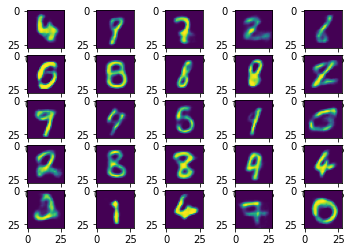

In [167]:
imgs = 5
f, axarr = plt.subplots(imgs,imgs)

for x in range(imgs):
  for y in range(imgs):
    random = torch.randn(10)
    random = random.to(device)
    img = net.decode(random).reshape(28,28)
    img = img.detach().cpu().numpy()
    axarr[x,y].imshow(img)